In [10]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
from os import listdir
%pylab inline

Populating the interactive namespace from numpy and matplotlib


c:\python\python38\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['grid', 'step', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [63]:
class grid_class(object):
    def __init__(self, size_x=100, size_y=100, coeff=0.5):
        self.data=np.random.choice([0, 1], (size_x, size_y), replace=True, p=[coeff, 1.0-coeff])
        self.new_data = self.data.copy()
        self.size_x=size_x
        self.size_y=size_y
        self.coeff=coeff
        #print("Python")
    def plot(self):
        plt.figure(figsize=(5,5))
        plt.imshow(self.data, aspect='auto', interpolation='none')
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])
    
    def count_neighbours(self, i=0, j=0):
        count=0
        
        for incx in [-1,0,1]:
            for incy in [-1,0,1]:
                if ((incx!=0) or (incy!=0)):
                    ix=i+incx
                    iy=j+incy
                    
                    if ix==-1:
                        ix+=self.size_x;
                    elif ix==self.size_x:
                        ix=0
                        
                    if iy==-1:
                        iy+=self.size_y;
                    elif iy==self.size_y:
                        iy=0
                        
                    if self.data[ix,iy]==1:
                        count+=1
                    
        return count
    
    def update(self,i=0,j=0):
        count=self.count_neighbours(i,j)
        change=0
        
        # if dead stay dead unless exactly three alive
        # if alive stay alive only when two or three alive
        # flip state otherwise
        if (self.data[i,j]==0) and (count==3) or (self.data[i,j]==1) and ((count<2) or (count>3)):
            self.new_data[i,j]=1-self.data[i,j]
            change=1

        return change
                        
    def one_time_step(self):
        # go through the map, update each cell
        change_count=0
        
        for i in range(self.size_x):
            for j in range(self.size_y):
                change_count+=self.update(i,j)
        self.data = self.new_data.copy()
        return change_count

In [64]:
#Load cython extension

In [5]:
%load_ext cython

In [9]:
%%cython -a
import numpy as np
import matplotlib.pyplot as plt
import imageio
from os import listdir
from cpython cimport array
import array

cdef class grid_class_cy(object):
    cdef int size_x
    cdef int size_y
    cdef float coeff
    cdef int[:,:] data
    cdef int[:,:] new_data
    def __cinit__(self, int _size_x=100, int _size_y=100, float coeff=0.5):
        self.data=np.random.choice([0, 1], (_size_x, _size_y), replace=True, p=[coeff, 1.0-coeff])
        self.new_data = self.data.copy()
        self.size_x=_size_x
        self.size_y=_size_y
        self.coeff=coeff
        #print("Cython")
    cpdef plot(self):
        plt.figure(figsize=(5,5))
        plt.imshow(self.data, aspect='auto', interpolation='none')
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])
    cpdef get_data(self):
        return self.data
    cpdef count_neighbours(self, int i=0, int j=0):
        cdef int count=0
        cdef int incx
        cdef int incy,ix,iy
        cdef int[3] arr = [-1,0,1]
        for incx in arr:
            for incy in arr:
                if ((incx!=0) or (incy!=0)):
                    ix=i+incx
                    iy=j+incy
                    
                    if ix==-1:
                        ix+=self.size_x;
                    elif ix==self.size_x:
                        ix=0
                        
                    if iy==-1:
                        iy+=self.size_y;
                    elif iy==self.size_y:
                        iy=0
                        
                    if self.data[ix,iy]==1:
                        count+=1
                    
        return count
    
    cpdef update(self,int i=0,int j=0):
        cdef int count=self.count_neighbours(i,j)
        cdef int change=0
        
        # if dead stay dead unless exactly three alive
        # if alive stay alive only when two or three alive
        # flip state otherwise
        if (self.data[i,j]==0) and (count==3) or (self.data[i,j]==1) and ((count<2) or (count>3)):
            self.new_data[i,j]=1-self.data[i,j]
            change=1

        return change
                        
    cpdef one_time_step(self):
        # go through the map, update each cell
        cdef int change_count=0
        
        for i in range(self.size_x):
            for j in range(self.size_y):
                change_count+=self.update(i,j)
        self.data = self.new_data.copy()
        return change_count

160 µs ± 2.67 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


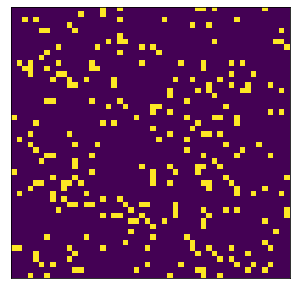

In [73]:
%timeit grid_class_cy(50,50,0.9)
grid_cy=grid_class_cy(50,50,0.9)
grid_cy.plot()

165 µs ± 17.6 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


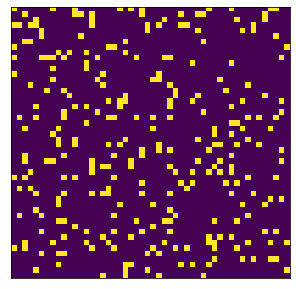

In [68]:
%timeit grid_py=grid_class(50,50,0.9)
grid_py=grid_class(50,50,0.9)
grid_py.plot()

450 µs ± 59.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
22.3 ms ± 741 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


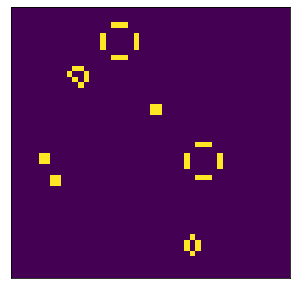

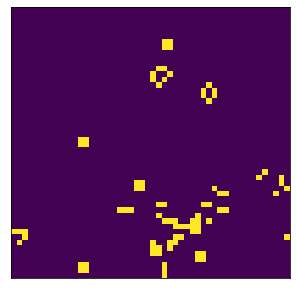

In [75]:
%timeit grid_cy.one_time_step()
%timeit grid_py.one_time_step()
grid_cy.plot()
grid_py.plot()

# Multi process

#### Save the python code

In [6]:
%%writefile grid_classes.pyx
from mpi4py import MPI
import numpy as np
import matplotlib.pyplot as plt
import imageio
from os import listdir
from cpython cimport array
import array
# Cython class for size != 1
cdef class grid_class_1(object):
    #cdef int size_x
    #cdef int size_y
    #cdef float coeff
    #cdef int[:,:] data
    #cdef int[:,:] new_data
    def __init__(self, int _size_x=100, int _size_y=100, float coeff=0.5):
        self.data = np.random.choice([0, 1], (_size_x, _size_y), replace=True, p=[coeff, 1.0 - coeff])
        self.new_data = self.data.copy()
        self.size_x = _size_x
        self.size_y = _size_y
        self.coeff = coeff
    
    cpdef get_data(self):
        return self.data.copy()
    
    cpdef get_new_data(self):
        return self.new_data.copy()
    
    cpdef set_new_data(self, data):
        self.new_data = data
    
    cpdef set_data(self, data):
        self.data = data
    
    cpdef set_new_data_by_idx(self,int idx, data):
        self.new_data = data
    
    cpdef set_data_by_idx(self,int idx, data):
        self.data = data
    
    cpdef count_neighbours(self, int i=0, int j=0):
        cdef int count=0
        cdef int incx
        cdef int incy,ix,iy
        cdef int[3] arr = [-1,0,1]
        for incx in arr:
            for incy in [-1, 0, 1]:
                if ((incx != 0) or (incy != 0)):
                    ix = i + incx
                    iy = j + incy
                    
                    if ix == -1:
                        print('error')
                    elif ix == self.size_x:
                        print('error')
                    if iy == -1:
                        iy += self.size_y;
                    elif iy == self.size_y:
                        iy = 0
                    if self.data[ix, iy] == 1:
                        count += 1
        return count
   
    cpdef update(self, int i=0, int j=0):
        cdef int count=self.count_neighbours(i,j)
        cdef int change=0
        # if dead stay dead unless exactly three alive
        # if alive stay alive only when two or three alive
        # flip state otherwise
        if (self.data[i, j] == 0) and (count == 3) or (self.data[i, j] == 1) and ((count < 2) or (count > 3)):
            self.new_data[i, j] = 1 - self.data[i, j]
            change = 1
        return change
    cpdef one_time_step(self):
        # go through the map, update each cell
        cdef int change_count = 0
        for i in range(1,self.size_x-1):
            for j in range(self.size_y):
                change_count += self.update(i, j)
        self.data = self.new_data.copy()
        return change_count

cdef class grid_class_0(object):
    #cdef int size_x
    #cdef int size_y
    #cdef float coeff
    #cdef int[:,:] data
    #cdef int[:,:] new_data
    def __init__(self, int _size_x=100, int _size_y=100, float coeff=0.5):
        self.data=np.random.choice([0, 1], (_size_x, _size_y), replace=True, p=[coeff, 1.0-coeff])
        self.new_data = self.data.copy()
        self.size_x=_size_x
        self.size_y=_size_y
        self.coeff=coeff
        #print("Cython")
    
    cpdef get_data(self):
        return self.data.copy()
    
    cpdef get_new_data(self):
        return self.new_data.copy()
    
    cpdef set_new_data(self,data):
        self.new_data = data
    
    cpdef set_data(self,data):
        self.data = data
    
    cpdef set_new_data_by_idx(self,int idx, data):
        self.new_data[idx] = data
    
    cpdef set_data_by_idx(self,int idx, data):
        self.data[idx] = data
    
    cpdef set_size_x(self,int x):
        self.size_x = x
    
    cpdef set_size_y(self,int y):
        self.size_y = y
    
    cpdef plot(self):
        plt.figure(figsize=(5, 5))
        plt.imshow(self.data, aspect='auto', interpolation='none')
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])

    cpdef count_neighbours(self, int i=0, int j=0):
        cdef int count = 0
        cdef int incx
        cdef int incy,ix,iy
        cdef int[3] arr = [-1,0,1]
        for incx in [-1, 0, 1]:
            for incy in [-1, 0, 1]:
                if ((incx != 0) or (incy != 0)):
                    ix = i + incx
                    iy = j + incy
                    if ix == -1:
                        ix += self.size_x;
                    elif ix == self.size_x:
                        ix = 0
                    if iy == -1:
                        iy += self.size_y;
                    elif iy == self.size_y:
                        iy = 0
                    if self.data[ix, iy] == 1:
                        count += 1
        return count

    cpdef update(self,int i=0,int j=0):
        cdef int count = self.count_neighbours(i, j)
        cdef int change = 0
        # if dead stay dead unless exactly three alive
        # if alive stay alive only when two or three alive
        # flip state otherwise
        if (self.data[i, j] == 0) and (count == 3) or (self.data[i, j] == 1) and ((count < 2) or (count > 3)):
            self.new_data[i, j] = 1 - self.data[i, j]
            change = 1
        return change
    cpdef one_time_step(self):
        # go through the map, update each cell
        cdef int change_count = 0
        for i in range(self.size_x):
            for j in range(self.size_y):
                change_count += self.update(i, j)
        self.data = self.new_data.copy()
        return change_count

Overwriting grid_classes.pyx


#### Make setup file

In [1]:
%%writefile setup_gridclasses.py
from setuptools import setup
from Cython.Build import cythonize

setup(
    name='Grid class',
    ext_modules=cythonize("grid_classes.pyx"),
    zip_safe=False,
)

Overwriting setup_gridclasses.py


#### Build the gridclasses

In [2]:
!python setup_gridclasses.py build_ext --inplace

running build_ext
copying build\lib.win-amd64-3.8\grid_classes.cp38-win_amd64.pyd -> 


In [3]:
from grid_classes import grid_class_0, grid_class_1

In [4]:
grid = grid_class_0()

AttributeError: 'grid_classes.grid_class_0' object has no attribute 'data'

In [159]:
grid.set_data()

TypeError: set_data() takes exactly one argument (0 given)

In [161]:
%%cython -a
from mpi4py import MPI
import numpy as np
import matplotlib.pyplot as plt
import imageio
from os import listdir
from cpython cimport array
import array
from grid_classes2 import grid_class_0, grid_class_1
comm = MPI.COMM_WORLD
cdef int rank = comm.Get_rank()
size = comm.Get_size()

cdef int x = 50
cdef int y = 70
cdef days = 98
np.random.seed(42)

if size!=1:
    glider_gun =\
[[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
 [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
 [1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]

    X = np.zeros((x, y))
    X[1:10,1:37] = glider_gun
    grid=grid_class_1(x,y,0.9)
    #grid.data = X.reshape((x,y)).copy()
    #grid.new_data = X.reshape((x,y)).copy()
    grid.set_data(X.reshape((x,y)).copy())
    grid.set_new_data(X.reshape((x,y)).copy())
    if size > x:
        size = x
    if rank<size:
        index_start = int(rank * x / size)
        index_end = int((rank+1) * x / size)

        if rank == size - 1:
            index_end = x
        up_n = rank - 1
        down_n = rank + 1
        if up_n == -1:
            up_n = size - 1
        if down_n == size:
            down_n = 0
        #data = grid.data.copy()
        data = grid.get_data()
        if up_n == size -1:
            my_data = np.concatenate([data[-1].reshape(1,y),
                      data[index_start:index_end],
                      data[int(down_n * x / size)].reshape(1,y)])
        else:
            my_data = np.concatenate([data[int((up_n+1) * x / size)-1].reshape(1,y),
                      data[index_start:index_end],
                      data[int(down_n * x / size)].reshape(1,y)])
        grid.set_data(my_data.copy())
        grid.set_new_data(my_data.copy())
        grid.set_size_x(my_data.shape[0])
        steps = [my_data[1:-1].copy()]
        for day in range(days):
            grid.one_time_step()
            my_up = grid.get_data()[1].copy()
            my_down = grid.get_data()[-2].copy()
            if rank%2 == 0:
                new_up = np.empty(my_up.shape)
                new_down = np.empty(my_down.shape)
                comm.Send(my_up, dest = up_n)
                comm.Recv(new_up, source=up_n)

                comm.Recv(new_down, source=down_n)
                comm.Send(my_down, dest=down_n)
            if rank % 2 == 1:
                new_down = np.empty(my_down.shape)
                new_up = np.empty(my_up.shape)
                comm.Recv(new_down, source=down_n)
                comm.Send(my_down, dest=down_n)

                comm.Send(my_up, dest=up_n)
                comm.Recv(new_up, source=up_n)
            grid.set_data_by_idx(0, new_up.copy())
            grid.set_data_by_idx(-1, new_down.copy())
            grid.set_new_data(grid.get_data())
            steps.append(grid.get_data()[1:-1].copy())
        steps = np.array(steps)
        print(steps.shape)
        with open('life_'+str(rank)+'.npy', 'wb') as f:
            np.save(f, steps)
else:
    
    glider_gun =\
[[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
 [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
 [1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]

    X = np.zeros((x, y))
    X[1:10,1:37] = glider_gun
    grid=grid_class_0(x,y,0.9)
    grid.set_data(X.reshape((x,y)).copy())
    grid.set_new_data(X.reshape((x,y)).copy())
    steps = [grid.get_data()]
    for day in range(days):
        grid.one_time_step()
        steps.append(grid.get_data())
    steps = np.array(steps)
    with open('life_' + str(rank) + '.npy', 'wb') as f:
        np.save(f, 100)


ValueError: Buffer dtype mismatch, expected 'int' but got 'double'

In [14]:
!mpiexec -n 4 python Task9.py

(99, 12, 70)
(99, 13, 70)
(99, 13, 70)
(99, 12, 70)


In [15]:
res = []
for i in range(4):
    with open('life_'+str(i)+'.npy', 'rb') as f:
        #print(np.load(f).shape)
        res.append(np.load(f))
res = np.concatenate(res,axis = 1)

In [16]:
res.shape

(99, 50, 70)

In [18]:
%mkdir game_of_life_pro_4

In [19]:
for i,step in enumerate(res):
    fig = plt.figure(figsize = (14,11))
    plt.imshow(step, cmap='Greys' )
    if i < 10:
        plt.savefig('game_of_life_pro_4/'+'0'+str(i)+'.png')
    else:
        plt.savefig('game_of_life_pro_4/'+str(i)+'.png')
    plt.close(fig)

In [18]:
from os import listdir
images = []
for filename in sorted(listdir('game_of_life_pro_4')):
    images.append(imageio.imread('game_of_life_pro_4/'+filename))
imageio.mimsave('game_of_life_pro_4/game_of_life.gif', images)

In [11]:
%mkdir game_of_life_1

# 3 different initial conditions

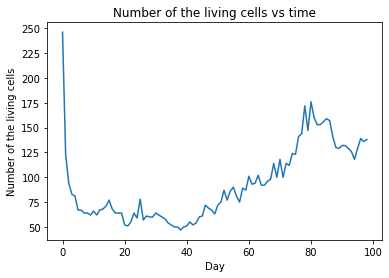

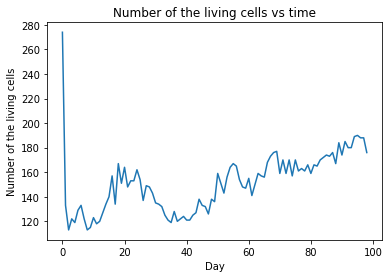

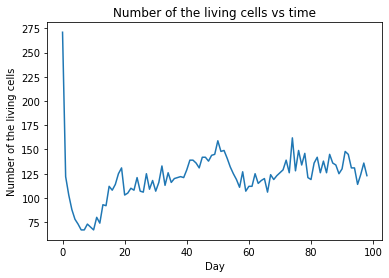

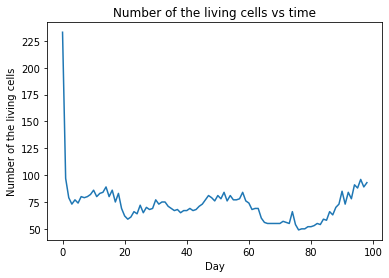

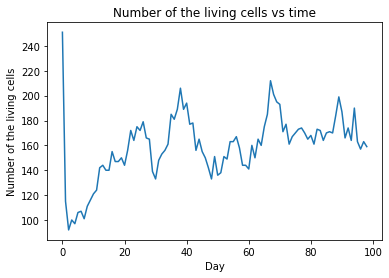

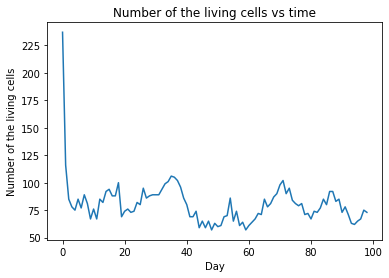

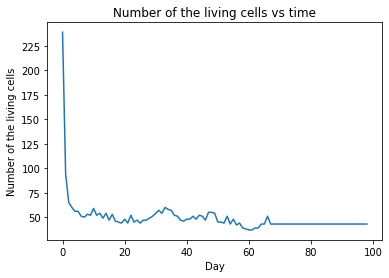

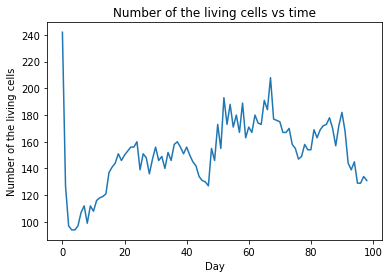

37 s ± 1.26 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
%%timeit
days = 99
grid=grid_class_cy(50,50,0.9)
living = []
steps = []
for day in range(days):
    living.append(np.sum(grid.get_data()))
    steps.append(grid.get_data().copy())
    grid.one_time_step()
steps = np.array(steps)
for i,step in enumerate(steps):
    fig = plt.figure(figsize = (14,11))
    plt.imshow(step, cmap='Greys' )
    if i < 10:
        plt.savefig('game_of_life_1/'+'0'+str(i)+'.png')
    else:
        plt.savefig('game_of_life_1/'+str(i)+'.png')
    plt.close(fig)
images = []
for filename in sorted(listdir('game_of_life_1')):
    images.append(imageio.imread('game_of_life_1/'+filename))
imageio.mimsave('game_of_life_1/game_of_life.gif', images)
plt.plot(living)
plt.title("Number of the living cells vs time")
plt.xlabel('Day')
plt.ylabel('Number of the living cells')
plt.show()

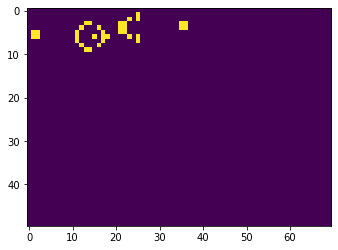

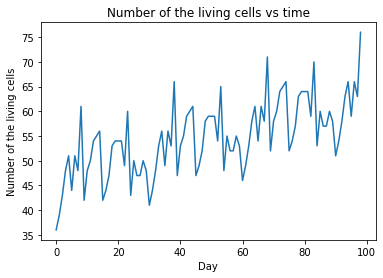

In [140]:
glider_gun =\
[[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
 [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1],
 [1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
 [0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]]

X = np.zeros((50, 70))
X[1:10,1:37] = glider_gun

days = 99
grid1=grid_class(50,70,0.9)
grid1.data = X.reshape((50,70)).copy()
grid1.new_data = X.reshape((50,70)).copy()
plt.imshow(grid1.data)
plt.show()
living = []
steps = []
for day in range(days):
    living.append(np.sum(grid1.data))
    steps.append(grid1.data.copy())
    grid1.one_time_step()
steps = np.array(steps)
for i,step in enumerate(steps):
    fig = plt.figure(figsize = (14,11))
    plt.imshow(step, cmap='Greys' )
    if i < 10:
        plt.savefig('game_of_life_2/'+'0'+str(i)+'.png')
    else:
        plt.savefig('game_of_life_2/'+str(i)+'.png')
    plt.close(fig)
images = []
for filename in sorted(listdir('game_of_life_2')):
    images.append(imageio.imread('game_of_life_2/'+filename))
imageio.mimsave('game_of_life_2/game_of_life.gif', images)
plt.plot(living)
plt.title("Number of the living cells vs time")
plt.xlabel('Day')
plt.ylabel('Number of the living cells')
plt.show()

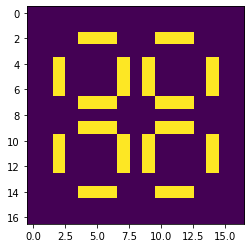

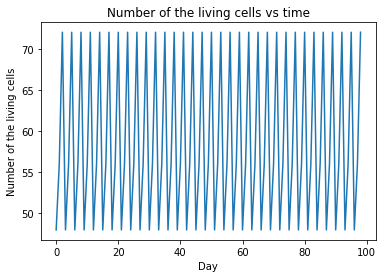

In [141]:
X = np.zeros((17, 17))
X[2, 4:7] = 1
X[4:7, 7] = 1
X += X.T
X += X[:, ::-1]
X += X[::-1, :]

days = 99
grid1=grid_class(17,17,0.9)
grid1.data = X.reshape((17,17)).copy()
grid1.new_data = X.reshape((17,17)).copy()
plt.imshow(grid1.data)
plt.show()
living = []
steps = []
for day in range(days):
    living.append(np.sum(grid1.data))
    steps.append(grid1.data.copy())
    grid1.one_time_step()
steps = np.array(steps)
for i,step in enumerate(steps):
    fig = plt.figure(figsize = (14,11))
    plt.imshow(step, cmap='Greys' )
    if i < 10:
        plt.savefig('game_of_life_3/'+'0'+str(i)+'.png')
    else:
        plt.savefig('game_of_life_3/'+str(i)+'.png')
    plt.close(fig)
images = []
for filename in sorted(listdir('game_of_life_3')):
    images.append(imageio.imread('game_of_life_3/'+filename))
imageio.mimsave('game_of_life_3/game_of_life.gif', images)
plt.plot(living)
plt.title("Number of the living cells vs time")
plt.xlabel('Day')
plt.ylabel('Number of the living cells')
plt.show()